# **WiDS Datathon 2025 - Unraveling the Mysteries of the Female Brain: Sex Patterns in ADHD**
## **Authors:** Sergiu Buhatel and Ramy El Gharbawy

## **Import the necessary libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cbook import boxplot_stats
import seaborn as sns

# To scale the data using z-score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# Algorithms to use
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Metrics to evaluate the model
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report,recall_score,precision_score, accuracy_score

# For tuning the model
from sklearn.model_selection import GridSearchCV
from IPython.display import display, HTML, Markdown

import joblib  # For saving and loading the model

from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay
from IPython.display import display, Markdown

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

## **Data Overview**

- Reading the dataset
- Understanding the shape of the dataset
- Checking the data types
- Checking for missing values

In [2]:
# Loading the datasets
df_train_categorical = pd.read_excel('./Data/TRAIN/TRAIN_CATEGORICAL_METADATA.xlsx').set_index("participant_id")
df_train_functional = pd.read_csv('./Data/TRAIN/TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv').set_index("participant_id")
df_train_quantitative = pd.read_excel('./Data/TRAIN/TRAIN_QUANTITATIVE_METADATA.xlsx').set_index("participant_id")
df_training_solutions = pd.read_excel('./Data/TRAIN/TRAINING_SOLUTIONS.xlsx').set_index("participant_id")

df_test_categorical = pd.read_excel('./Data/TEST/TEST_CATEGORICAL.xlsx').set_index("participant_id")
df_test_functional = pd.read_csv('./Data/TEST/TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv').set_index("participant_id")
df_test_quantitative = pd.read_excel('./Data/TEST/TEST_QUANTITATIVE_METADATA.xlsx').set_index("participant_id")

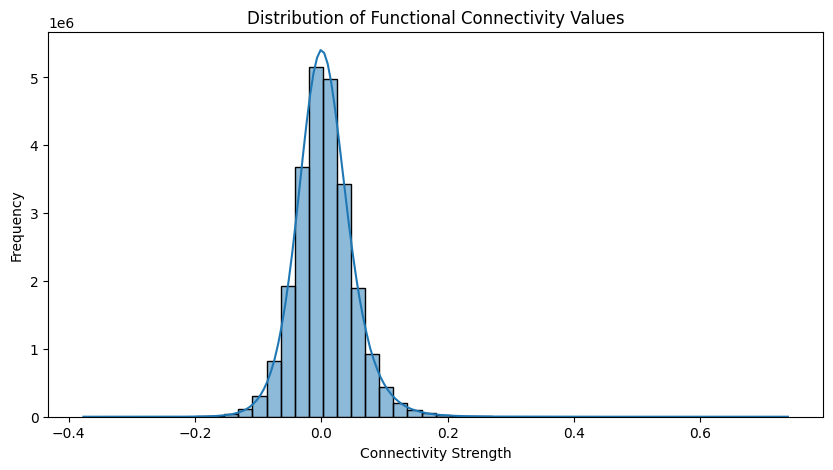

In [3]:
# PLotting a histogram of the functional connectivity values
plt.figure(figsize=(10, 5))
sns.histplot(df_train_functional.values.flatten(), bins=50, kde=True)
plt.xlabel("Connectivity Strength")
plt.ylabel("Frequency")
plt.title("Distribution of Functional Connectivity Values")
plt.show()

Is the matrix symmetric? True


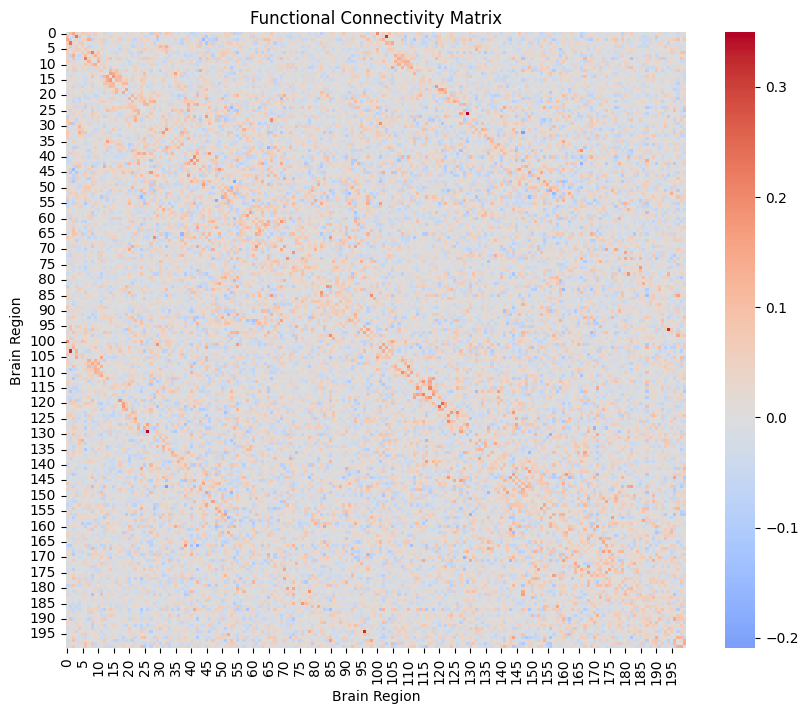

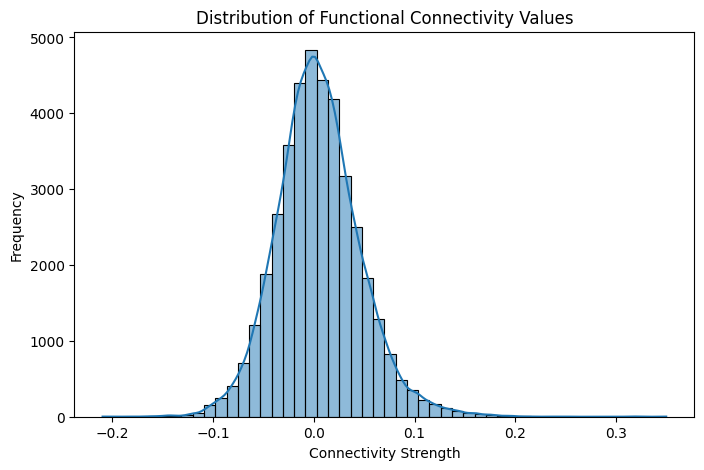

In [4]:
values = df_train_functional.iloc[0, :].values

if values.shape[0] == 19900:  # Likely an upper-triangle representation
    n = 200  # Assuming 200 regions
    matrix = np.zeros((n, n))  # Create empty symmetric matrix

    # Get upper triangle indices
    triu_indices = np.triu_indices(n, k=1)

    # Fill the upper triangle
    matrix[triu_indices] = values

    # Mirror to make it symmetric
    matrix = matrix + matrix.T

#  Check symmetry
print("Is the matrix symmetric?", np.allclose(matrix, matrix.T, atol=1e-5))

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(matrix, cmap="coolwarm", center=0)
plt.title("Functional Connectivity Matrix")
plt.xlabel("Brain Region")
plt.ylabel("Brain Region")
plt.show()

# Plot histogram of values
plt.figure(figsize=(8, 5))
sns.histplot(matrix.flatten(), bins=50, kde=True)
plt.title("Distribution of Functional Connectivity Values")
plt.xlabel("Connectivity Strength")
plt.ylabel("Frequency")
plt.show()

In [5]:
# Copying data to another variable to avoid any changes to original data
data_train_categorical=df_train_categorical.copy()
data_train_functional=df_train_functional.copy()
data_train_quantitative=df_train_quantitative.copy()
data_training_solutions=df_training_solutions.copy()

data_test_categorical=df_test_categorical.copy()
data_test_functional=df_test_functional.copy()
data_test_quantitative=df_test_quantitative.copy()

In [6]:
def display_head_with_scroll(data):
    # Convert the DataFrame to HTML and wrap it with a div that enables horizontal scrolling
    html = data.head().to_html()
    html_with_scroll = f'<div style="overflow-x: auto; white-space: nowrap;">{html}</div>'
    
    # Display the HTML with the scroll
    display(HTML(html_with_scroll))

# Check for null values
def columns_containing_null(df):
    # Get the count of null values per column
    null_count = df.isnull().sum()
    
    # Filter to show only columns with null values
    columns_with_nulls = null_count[null_count > 0]
    
    print("\nColumns containing null and how many values are null:\n" + str(columns_with_nulls) + "\n")

def summary_statistics(data):
    # Creating numerical columns
    num_cols = data.select_dtypes('number').columns
    
    # Checking the descriptive statistics of the numerical columns
    html = data[num_cols].describe().T.to_html()

    html_with_scroll = f'<div style="overflow-x: auto; white-space: nowrap;">{html}</div>'
    
    # Display the HTML with the scroll
    display(HTML(html_with_scroll))
    
def display_data(data, title = None):
    if title is not None:
        # Display the title as an h1 header
        display(HTML(f'<h3>{title}</h1>'))
        
    display_head_with_scroll(data)

    # Get shape of the dataset in terms of number of rows and number of colums
    print("Shape:" + str(data.shape) + "\n")
    
    # Check the data types as part of the info of the data
    data_train_categorical.info() 

    # Check for null values
    columns_containing_null(data)

    # Summary statistics
    summary_statistics(data)

# Function to get participant IDs with rows that have null values
def get_participant_ids_with_nulls(df):
    # Identify rows with any null value
    rows_with_nulls = df[df.isnull().any(axis=1)]
    
    # Get the participant_id (index) of those rows
    participant_ids_with_nulls = rows_with_nulls.index.tolist()
    
    return participant_ids_with_nulls
    
def display_shape_and_null_data(data, title = None):
    if title is not None:
        # Display the title as an h1 header
        display(HTML(f'<h3>{title}</h1>'))

    # Get shape of the dataset in terms of number of rows and number of colums
    print("Shape:" + str(data.shape) + "\n")

    # Check for null values
    participant_ids_with_nulls = get_participant_ids_with_nulls(data)
    print("Number of columns with null value:" + str(len(participant_ids_with_nulls)))

In [7]:
display_data(data_train_categorical, "TRAIN_CATEGORICAL_METADATA.xlsx")

,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
participant_id,,,,,,,,,
UmrK0vMLopoR,2016,1,0.0,0,1,21,45,21,45
CPaeQkhcjg7d,2019,3,1.0,2,3,15,15,0,0
Nb4EetVPm3gs,2016,1,1.0,8,1,18,40,0,0
p4vPhVu91o4b,2018,3,0.0,8,3,15,30,18,0
M09PXs7arQ5E,2019,3,0.0,1,3,15,20,0,0


Shape:(1213, 9)

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, UmrK0vMLopoR to k8HhHnnu2wmt
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Basic_Demos_Enroll_Year           1213 non-null   int64  
 1   Basic_Demos_Study_Site            1213 non-null   int64  
 2   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 3   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 4   MRI_Track_Scan_Location           1213 non-null   int64  
 5   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 6   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 7   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 8   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 94.8+ KB

Columns containing null and how many values are null:
PreInt_Demos_Fam_Child_Ethnicity    11
dtype: int64



,count,mean,std,min,25%,50%,75%,max
Basic_Demos_Enroll_Year,1213.0,2017.652102,1.122522,2015.0,2017.0,2018.0,2019.0,2020.0
Basic_Demos_Study_Site,1213.0,2.014839,1.135147,1.0,1.0,1.0,3.0,4.0
PreInt_Demos_Fam_Child_Ethnicity,1202.0,0.424293,0.687470,0.0,0.0,0.0,1.0,3.0
PreInt_Demos_Fam_Child_Race,1213.0,2.080791,3.164636,0.0,0.0,0.0,2.0,11.0
MRI_Track_Scan_Location,1213.0,2.288541,0.758348,0.0,2.0,2.0,3.0,4.0
Barratt_Barratt_P1_Edu,1213.0,17.641385,4.004639,0.0,15.0,18.0,21.0,21.0
Barratt_Barratt_P1_Occ,1213.0,24.892828,17.025899,0.0,0.0,30.0,40.0,45.0
Barratt_Barratt_P2_Edu,1213.0,14.122012,7.201023,0.0,12.0,18.0,21.0,21.0
Barratt_Barratt_P2_Occ,1213.0,24.719703,17.171113,0.0,5.0,30.0,40.0,45.0


In [8]:
#display_data(data_train_functional, "TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv")

In [9]:
display_data(data_train_quantitative, "TRAIN_QUANTITATIVE_METADATA.xlsx")

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
participant_id,,,,,,,,,,,,,,,,,,
UmrK0vMLopoR,40.00,13,3,10,47,13,11,28,0,6,1,5,0,5,1,0,10,NaN
CPaeQkhcjg7d,-94.47,14,3,13,34,18,23,30,0,18,6,8,7,8,10,4,5,NaN
Nb4EetVPm3gs,-46.67,14,4,10,35,16,10,29,1,14,2,8,5,7,6,4,9,8.239904
p4vPhVu91o4b,-26.68,10,5,12,39,19,16,28,6,24,4,16,9,10,8,4,6,NaN
M09PXs7arQ5E,0.00,14,5,15,40,20,24,28,1,18,4,11,4,10,7,3,9,8.940679


Shape:(1213, 18)

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, UmrK0vMLopoR to k8HhHnnu2wmt
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Basic_Demos_Enroll_Year           1213 non-null   int64  
 1   Basic_Demos_Study_Site            1213 non-null   int64  
 2   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 3   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 4   MRI_Track_Scan_Location           1213 non-null   int64  
 5   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 6   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 7   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 8   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 94.8+ KB

Columns containing null and how many values are null:
MRI_Track_Age_at_Scan    360
dtype: int64



,count,mean,std,min,25%,50%,75%,max
EHQ_EHQ_Total,1213.0,58.876917,49.855501,-100.0,45.600000,76.670000,93.400000,100.000000
ColorVision_CV_Score,1213.0,13.164880,2.780624,0.0,14.000000,14.000000,14.000000,14.000000
APQ_P_APQ_P_CP,1213.0,3.781533,1.376700,0.0,3.000000,3.000000,4.000000,12.000000
APQ_P_APQ_P_ID,1213.0,13.205276,3.811772,0.0,11.000000,13.000000,16.000000,28.000000
APQ_P_APQ_P_INV,1213.0,39.374279,6.245928,0.0,36.000000,40.000000,43.000000,50.000000
APQ_P_APQ_P_OPD,1213.0,17.785655,3.764112,0.0,16.000000,18.000000,20.000000,28.000000
APQ_P_APQ_P_PM,1213.0,16.393240,5.376994,0.0,13.000000,16.000000,19.000000,37.000000
APQ_P_APQ_P_PP,1213.0,25.246496,3.950529,0.0,23.000000,26.000000,28.000000,30.000000
SDQ_SDQ_Conduct_Problems,1213.0,2.059357,2.023322,0.0,0.000000,2.000000,3.000000,10.000000
SDQ_SDQ_Difficulties_Total,1213.0,12.122836,6.577207,0.0,7.000000,12.000000,17.000000,34.000000


In [10]:
display_data(data_training_solutions, "TRAINING_SOLUTIONS.xlsx")
print("\nList of possible values for 'ADHD_Outcome': " + str(data_training_solutions['ADHD_Outcome'].unique()))
print("\nList of possible values for 'Sex_F': " + str(data_training_solutions['Sex_F'].unique()))

,ADHD_Outcome,Sex_F
participant_id,,
UmrK0vMLopoR,1,1
CPaeQkhcjg7d,1,0
Nb4EetVPm3gs,1,0
p4vPhVu91o4b,1,1
M09PXs7arQ5E,1,1


Shape:(1213, 2)

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, UmrK0vMLopoR to k8HhHnnu2wmt
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Basic_Demos_Enroll_Year           1213 non-null   int64  
 1   Basic_Demos_Study_Site            1213 non-null   int64  
 2   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 3   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 4   MRI_Track_Scan_Location           1213 non-null   int64  
 5   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 6   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 7   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 8   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 94.8+ KB

Columns containing null and how many values are null:
Series([], dtype: int64)



,count,mean,std,min,25%,50%,75%,max
ADHD_Outcome,1213.0,0.685078,0.464676,0.0,0.0,1.0,1.0,1.0
Sex_F,1213.0,0.342951,0.474891,0.0,0.0,0.0,1.0,1.0



List of possible values for 'ADHD_Outcome': [1 0]

List of possible values for 'Sex_F': [1 0]


### **Observations**
- Two values are possble for '**ADHD_Outcome**': **1** and **0**. (**1** = **Yes** and **0** = **No**) 
- Two values are possible for '**Sex_F**': **1** and **0**. (**1** means **Female**, and **0** means **Male**)

In [11]:
display_data(data_test_categorical, "TEST_CATEGORICAL.xlsx")

,Basic_Demos_Enroll_Year,Basic_Demos_Study_Site,PreInt_Demos_Fam_Child_Ethnicity,PreInt_Demos_Fam_Child_Race,MRI_Track_Scan_Location,Barratt_Barratt_P1_Edu,Barratt_Barratt_P1_Occ,Barratt_Barratt_P2_Edu,Barratt_Barratt_P2_Occ
participant_id,,,,,,,,,
Cfwaf5FX7jWK,2022,4,0.0,0.0,4,21.0,30.0,18.0,30.0
vhGrzmvA3Hjq,2023,4,0.0,0.0,4,21.0,45.0,NaN,30.0
ULliyEXjy4OV,2022,4,0.0,0.0,4,21.0,40.0,18.0,40.0
LZfeAb1xMtql,2022,4,0.0,0.0,3,21.0,45.0,21.0,45.0
EnFOUv0YK1RG,2022,4,2.0,0.0,4,18.0,0.0,21.0,45.0


Shape:(304, 9)

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, UmrK0vMLopoR to k8HhHnnu2wmt
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Basic_Demos_Enroll_Year           1213 non-null   int64  
 1   Basic_Demos_Study_Site            1213 non-null   int64  
 2   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 3   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 4   MRI_Track_Scan_Location           1213 non-null   int64  
 5   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 6   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 7   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 8   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 94.8+ KB

Columns containing null and how many values are null:
PreInt_Demos_Fam_Child_Ethnicity     3
PreInt_Demos_Fam_Child_Ra

,count,mean,std,min,25%,50%,75%,max
Basic_Demos_Enroll_Year,304.0,2022.197368,0.494718,2019.0,2022.0,2022.0,2022.0,2023.0
Basic_Demos_Study_Site,304.0,4.009868,0.099012,4.0,4.0,4.0,4.0,5.0
PreInt_Demos_Fam_Child_Ethnicity,301.0,0.355482,0.665741,0.0,0.0,0.0,1.0,3.0
PreInt_Demos_Fam_Child_Race,298.0,2.231544,3.392914,0.0,0.0,0.0,3.0,11.0
MRI_Track_Scan_Location,304.0,3.638158,0.481326,3.0,3.0,4.0,4.0,4.0
Barratt_Barratt_P1_Edu,303.0,19.128713,2.680553,3.0,18.0,21.0,21.0,21.0
Barratt_Barratt_P1_Occ,303.0,29.389439,16.484193,0.0,25.0,35.0,45.0,45.0
Barratt_Barratt_P2_Edu,268.0,18.458955,3.087093,3.0,18.0,18.0,21.0,21.0
Barratt_Barratt_P2_Occ,262.0,35.763359,11.978162,0.0,30.0,40.0,45.0,45.0


In [12]:
#display_data(data_test_functional, "TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv")

In [13]:
display_data(data_test_quantitative, "TEST_QUANTITATIVE_METADATA.xlsx")

,EHQ_EHQ_Total,ColorVision_CV_Score,APQ_P_APQ_P_CP,APQ_P_APQ_P_ID,APQ_P_APQ_P_INV,APQ_P_APQ_P_OPD,APQ_P_APQ_P_PM,APQ_P_APQ_P_PP,SDQ_SDQ_Conduct_Problems,SDQ_SDQ_Difficulties_Total,SDQ_SDQ_Emotional_Problems,SDQ_SDQ_Externalizing,SDQ_SDQ_Generating_Impact,SDQ_SDQ_Hyperactivity,SDQ_SDQ_Internalizing,SDQ_SDQ_Peer_Problems,SDQ_SDQ_Prosocial,MRI_Track_Age_at_Scan
participant_id,,,,,,,,,,,,,,,,,,
Cfwaf5FX7jWK,60.03,14.0,5.0,16.0,41.0,19.0,11.0,26.0,2.0,12.0,3.0,9.0,2.0,7.0,3.0,0.0,8.0,8.992813
vhGrzmvA3Hjq,86.71,12.0,3.0,13.0,43.0,18.0,15.0,28.0,2.0,16.0,8.0,5.0,7.0,3.0,11.0,3.0,9.0,12.324093
ULliyEXjy4OV,26.68,13.0,3.0,14.0,36.0,16.0,14.0,25.0,1.0,7.0,1.0,6.0,1.0,5.0,1.0,0.0,9.0,7.770933
LZfeAb1xMtql,93.38,13.0,3.0,19.0,41.0,17.0,18.0,27.0,4.0,15.0,4.0,10.0,8.0,6.0,5.0,1.0,6.0,9.304814
EnFOUv0YK1RG,-93.38,14.0,3.0,13.0,42.0,19.0,16.0,28.0,2.0,18.0,6.0,12.0,5.0,10.0,6.0,0.0,10.0,8.261350


Shape:(304, 18)

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, UmrK0vMLopoR to k8HhHnnu2wmt
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Basic_Demos_Enroll_Year           1213 non-null   int64  
 1   Basic_Demos_Study_Site            1213 non-null   int64  
 2   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 3   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 4   MRI_Track_Scan_Location           1213 non-null   int64  
 5   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 6   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 7   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 8   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 94.8+ KB

Columns containing null and how many values are null:
EHQ_EHQ_Total                  1
ColorVision_CV_Score          

,count,mean,std,min,25%,50%,75%,max
EHQ_EHQ_Total,303.0,59.144488,49.330962,-100.050000,50.060000,73.370000,93.380000,100.050000
ColorVision_CV_Score,295.0,13.240678,1.986273,0.000000,13.000000,14.000000,14.000000,14.000000
APQ_P_APQ_P_CP,289.0,3.321799,0.810248,2.000000,3.000000,3.000000,3.000000,8.000000
APQ_P_APQ_P_ID,289.0,13.259516,3.627411,6.000000,11.000000,13.000000,16.000000,23.000000
APQ_P_APQ_P_INV,289.0,39.633218,5.153586,20.000000,36.000000,40.000000,43.000000,50.000000
APQ_P_APQ_P_OPD,289.0,16.726644,3.360000,7.000000,14.000000,17.000000,19.000000,27.000000
APQ_P_APQ_P_PM,289.0,15.944637,4.931163,9.000000,12.000000,15.000000,19.000000,31.000000
APQ_P_APQ_P_PP,289.0,24.826990,3.283666,10.000000,23.000000,25.000000,28.000000,30.000000
SDQ_SDQ_Conduct_Problems,274.0,1.890511,1.973000,0.000000,0.000000,1.000000,3.000000,10.000000
SDQ_SDQ_Difficulties_Total,274.0,11.781022,6.056771,0.000000,7.000000,11.000000,16.000000,29.000000


In [14]:
# Check the data types as part of the info of the data
data_train_categorical.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1213 entries, UmrK0vMLopoR to k8HhHnnu2wmt
Data columns (total 9 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Basic_Demos_Enroll_Year           1213 non-null   int64  
 1   Basic_Demos_Study_Site            1213 non-null   int64  
 2   PreInt_Demos_Fam_Child_Ethnicity  1202 non-null   float64
 3   PreInt_Demos_Fam_Child_Race       1213 non-null   int64  
 4   MRI_Track_Scan_Location           1213 non-null   int64  
 5   Barratt_Barratt_P1_Edu            1213 non-null   int64  
 6   Barratt_Barratt_P1_Occ            1213 non-null   int64  
 7   Barratt_Barratt_P2_Edu            1213 non-null   int64  
 8   Barratt_Barratt_P2_Occ            1213 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 94.8+ KB


In [15]:
# Get three lists of participant_id that have at least one column as null
participant_ids_with_null_categorical = get_participant_ids_with_nulls(data_train_categorical)
participant_ids_with_null_quantitative = get_participant_ids_with_nulls(data_train_quantitative)
participant_ids_with_null_solutions = get_participant_ids_with_nulls(data_training_solutions)

participant_ids_with_null_test_categorical = get_participant_ids_with_nulls(data_test_categorical)
participant_ids_with_null_test_quantitative = get_participant_ids_with_nulls(data_test_quantitative)

# Aggregate the lists into one list excluding duplicates
aggregate_participant_ids_with_null = list(set(participant_ids_with_null_categorical) | 
                                           set(participant_ids_with_null_quantitative) | 
                                           set(participant_ids_with_null_solutions) |
                                           set(participant_ids_with_null_test_categorical)|
                                           set(participant_ids_with_null_test_quantitative))

## **Data Preprocessing**

### **Remove null items**
Remove items from all dataframes coresponding to any participant_id that has at least one column as null

In [16]:
# Remove items from dataframe coresponding to participant_id that have at least one column as null
def remove_items_based_on_participant_id_list(participant_id_list, df):
    # Remove rows where 'participant_id' (index) is in the list
    filtered_df = df[~df.index.isin(participant_id_list)]
    
    # Remove rows where any other column (except 'participant_id') is null
    filtered_df = filtered_df.dropna()
    
    return filtered_df

data_train_categorical = remove_items_based_on_participant_id_list(aggregate_participant_ids_with_null, data_train_categorical)
display_shape_and_null_data(data_train_categorical, "TRAIN_CATEGORICAL_METADATA.xlsx")

Shape:(845, 9)

Number of columns with null value:0


In [17]:
data_train_quantitative = remove_items_based_on_participant_id_list(aggregate_participant_ids_with_null, data_train_quantitative)
display_shape_and_null_data(data_train_quantitative, "TRAIN_QUANTITATIVE_METADATA.xlsx")

Shape:(845, 18)

Number of columns with null value:0


In [18]:
data_training_solutions = remove_items_based_on_participant_id_list(aggregate_participant_ids_with_null, data_training_solutions)
display_shape_and_null_data(data_training_solutions, "TRAINING_SOLUTIONS.xlsx")

Shape:(845, 2)

Number of columns with null value:0


In [19]:
data_test_categorical = remove_items_based_on_participant_id_list(aggregate_participant_ids_with_null, data_test_categorical)
display_shape_and_null_data(data_test_categorical, "TEST_CATEGORICAL.xlsx")

Shape:(214, 9)

Number of columns with null value:0


In [20]:
data_test_quantitative = remove_items_based_on_participant_id_list(aggregate_participant_ids_with_null, data_test_quantitative)
display_shape_and_null_data(data_test_quantitative, "TEST_QUANTITATIVE_METADATA.xlsx")

Shape:(214, 18)

Number of columns with null value:0


### TRAIN_FUNCTIONAL_CONNECTOME_MATRICES.csv

In [21]:
data_train_functional = remove_items_based_on_participant_id_list(aggregate_participant_ids_with_null, data_train_functional)

### TEST_FUNCTIONAL_CONNECTOME_MATRICES.csv

In [22]:
data_test_functional = remove_items_based_on_participant_id_list(aggregate_participant_ids_with_null, data_test_functional)

### **Aggregate training data and unseen data**
- Aggregate training data into data, and aggregate test data into unseen data
- Define label data

In [23]:
data_combined = pd.merge(data_train_quantitative, data_train_categorical, left_index=True, right_index=True, how="left")
data_combined_without_functional=data_combined.copy()
data_combined = pd.merge(data_combined, data_train_functional, left_index=True, right_index=True, how="left")
labels=data_training_solutions.copy()

unseen_data_combined = pd.merge(data_test_quantitative, data_test_categorical, left_index=True, right_index=True, how="left")
unseen_data_combined = pd.merge(unseen_data_combined, data_test_functional, left_index=True, right_index=True, how="left")

In [24]:
#display_data(data_combined, "DATA COMBINED")
data_combined.shape

(845, 19927)

In [25]:
#display_data(unseen_data_combined.shape, "UNSEEN DATA COMBINED")
unseen_data_combined.shape

(214, 19927)

In [26]:
labels.shape

(845, 2)

## **Data Exploration**

### **Numerical and Categorical Columns**

In [27]:
# Identify numerical and categorical columns
numerical_cols_without_functional = data_combined_without_functional.select_dtypes(include=['int64', 'float64']).columns
categorical_cols_without_functional = data_combined_without_functional.select_dtypes(include=['object']).columns

print("Numerical Columns: ", numerical_cols_without_functional)
print("Categorical Columns: ", categorical_cols_without_functional)

Numerical Columns:  Index(['EHQ_EHQ_Total', 'ColorVision_CV_Score', 'APQ_P_APQ_P_CP',
       'APQ_P_APQ_P_ID', 'APQ_P_APQ_P_INV', 'APQ_P_APQ_P_OPD',
       'APQ_P_APQ_P_PM', 'APQ_P_APQ_P_PP', 'SDQ_SDQ_Conduct_Problems',
       'SDQ_SDQ_Difficulties_Total', 'SDQ_SDQ_Emotional_Problems',
       'SDQ_SDQ_Externalizing', 'SDQ_SDQ_Generating_Impact',
       'SDQ_SDQ_Hyperactivity', 'SDQ_SDQ_Internalizing',
       'SDQ_SDQ_Peer_Problems', 'SDQ_SDQ_Prosocial', 'MRI_Track_Age_at_Scan',
       'Basic_Demos_Enroll_Year', 'Basic_Demos_Study_Site',
       'PreInt_Demos_Fam_Child_Ethnicity', 'PreInt_Demos_Fam_Child_Race',
       'MRI_Track_Scan_Location', 'Barratt_Barratt_P1_Edu',
       'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Edu',
       'Barratt_Barratt_P2_Occ'],
      dtype='object')
Categorical Columns:  Index([], dtype='object')


In [28]:
numerical_cols = data_combined.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data_combined.select_dtypes(include=['object']).columns

### **Correlation Analysis**
For numerical features, it’s important to explore how they correlate with each other and with the target variables. This will help identify potentially strong predictors and check for multicollinearity.

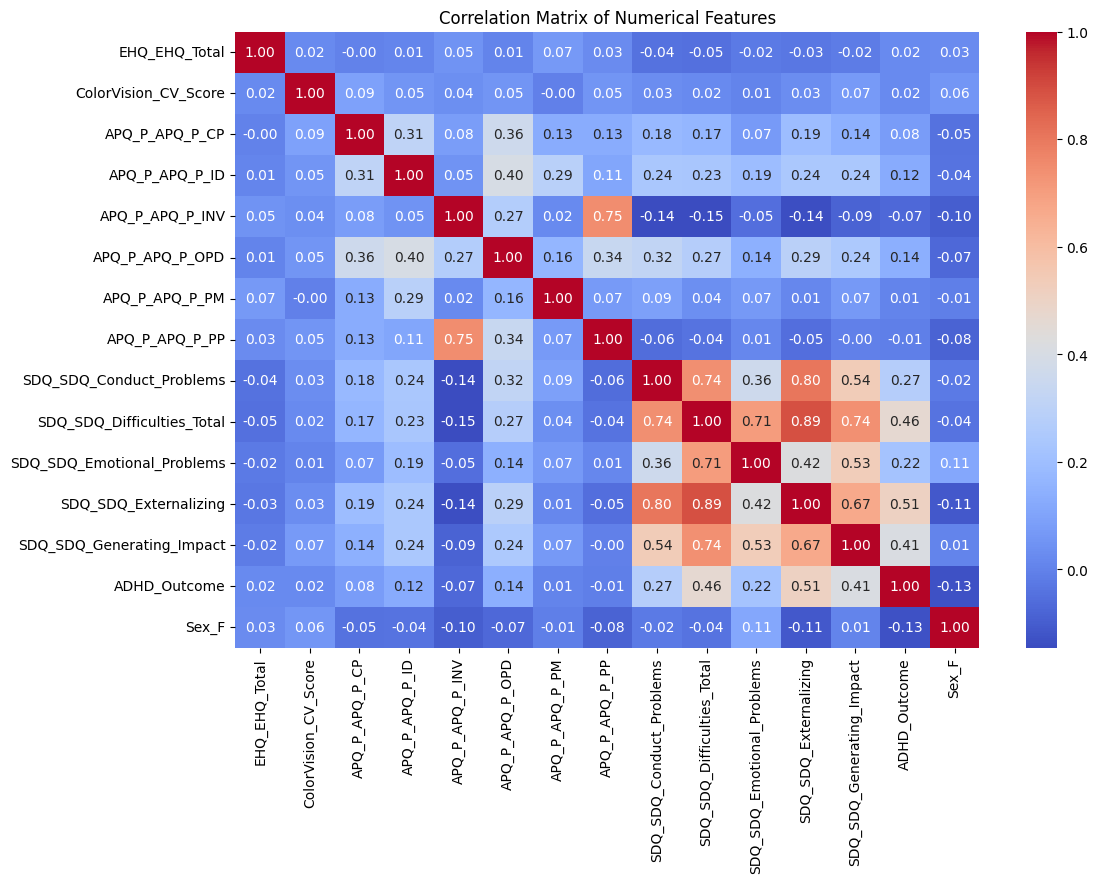

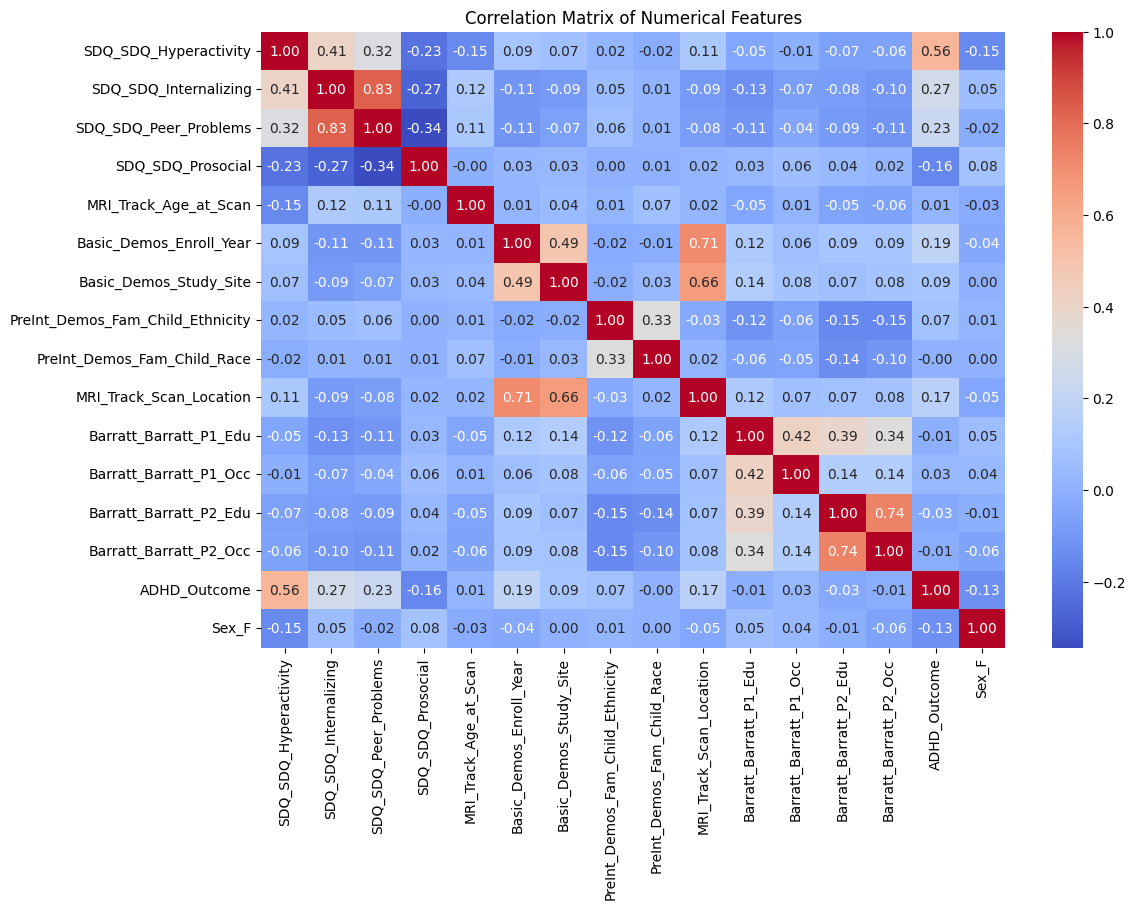

In [29]:
def corelation_analysis(data_combined, labels, numerical_cols, first_half = None):
    data_combined_with_labels = pd.merge(data_combined, labels, left_index=True, right_index=True, how="left")
    numerical_cols = list(numerical_cols)
    
    # Limit to the first half numerical columns (if more than half)
    if first_half is not None:
        threshold = int(len(numerical_cols)/2)
        if first_half is True:
            numerical_cols = numerical_cols[:threshold]
        else:
            numerical_cols = numerical_cols[threshold:]
    numerical_cols = numerical_cols + ["ADHD_Outcome", "Sex_F"]
    
    # Correlation heatmap for numerical features
    correlation_matrix = data_combined_with_labels[numerical_cols].corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title("Correlation Matrix of Numerical Features")
    plt.show()

for first_half in [True, False]:
    corelation_analysis(data_combined_without_functional, labels, numerical_cols_without_functional, first_half)

### **Observations**
The following predictors are not correlated with either **ADHD_Outcome** or **Sex_F**, and therefore can be dropped:
"**Basic_Demos_Study_Site**", "**MRI_Track_Scan_Location**", "**PreInt_Demos_Fam_Child_Ethnicity**", "**PreInt_Demos_Fam_Child_Race**", "**Barratt_Barratt_P1_Occ**", '**Barratt_Barratt_P2_Occ**".

### **Visualizing the Data**
Visualizing the relationship between features and target variables can provide deeper insights. Here are a few ideas for visualizations:

Boxplots/Histograms: To explore the distribution of numerical features.
Count Plots: For categorical variables, like Sex_F and ADHD_Outcome.

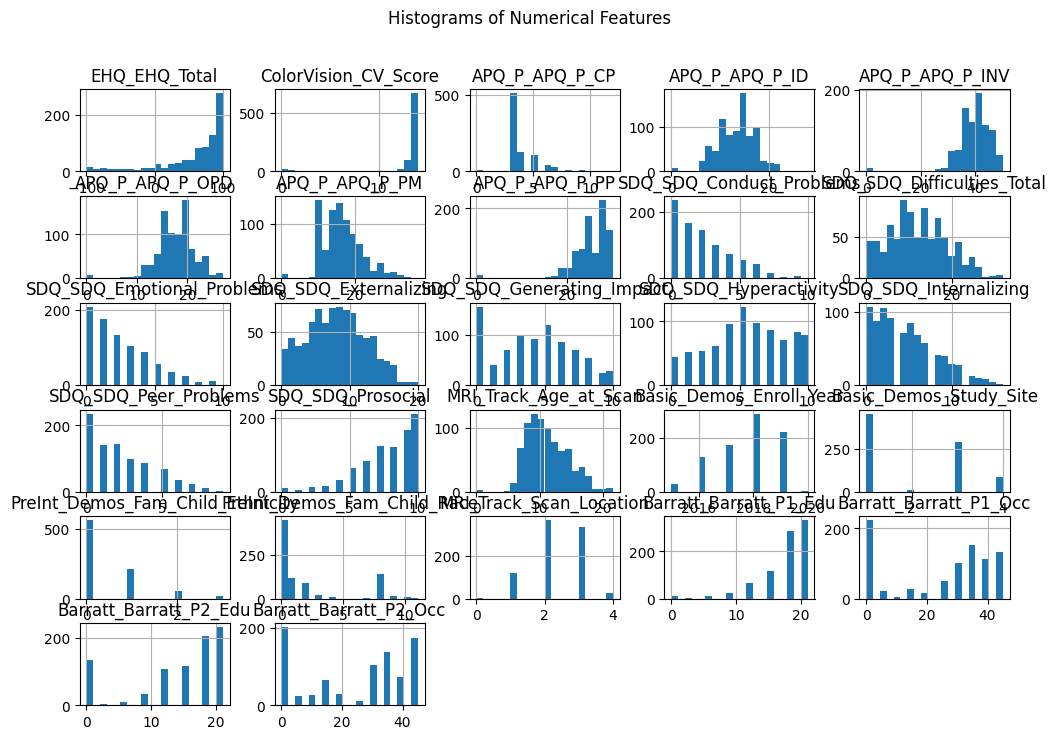

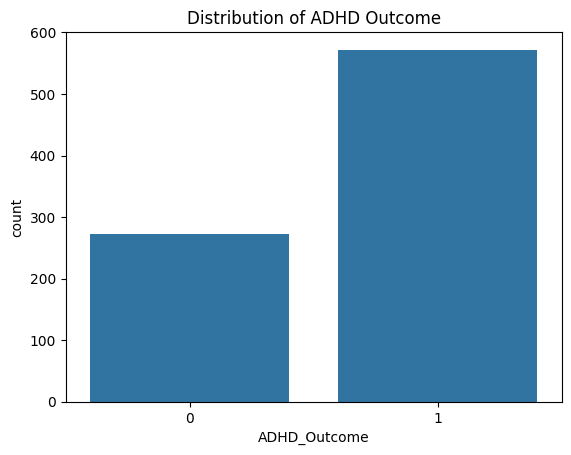

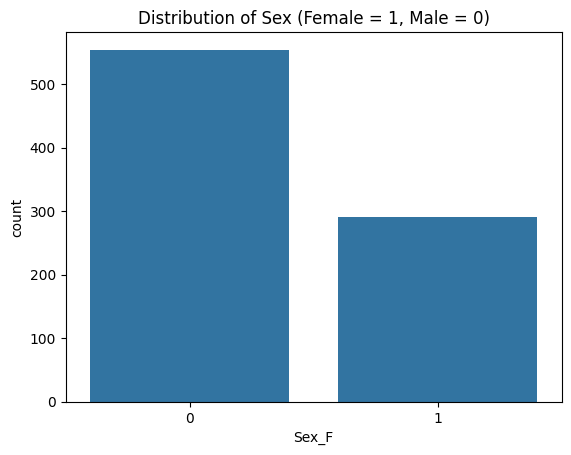

In [30]:
# Visualize the distribution of numerical features
data_combined_without_functional[numerical_cols_without_functional].hist(bins=20, figsize=(12, 8))
plt.suptitle("Histograms of Numerical Features")
plt.show()

# Visualize the distribution of ADHD_Outcome from the labels DataFrame
sns.countplot(x='ADHD_Outcome', data=labels)
plt.title('Distribution of ADHD Outcome')
plt.show()

# Visualize the distribution of Sex_F from the labels DataFrame
sns.countplot(x='Sex_F', data=labels)
plt.title('Distribution of Sex (Female = 1, Male = 0)')
plt.show()

## **Data Processing**

### **Feature Engineering**
Drop columns that are not correlated with the target variables, based on the observations in the correlation matrices.

In [31]:
# Drop columns 
drop_cols = [
    "Basic_Demos_Study_Site", "MRI_Track_Scan_Location", "PreInt_Demos_Fam_Child_Ethnicity",
    "PreInt_Demos_Fam_Child_Race", 'Barratt_Barratt_P1_Occ', 'Barratt_Barratt_P2_Occ'
]
data_combined.drop(drop_cols, axis=1, inplace=True)
unseen_data_combined.drop(drop_cols, axis=1, inplace=True)

numerical_cols = list(set(numerical_cols) - set(drop_cols))

### **Treating Outliers**
Check for outliers and if found, handle them as following:
Calculate the lower whisker and upper whisker for each numerical column and replace any smaller value than lower whisker with lower whisker, and any larger value than upper whisker with upper whisker. Only print the number of outliers.

In [32]:
def treating_outliers(data, num_columns):
    outliers_info = {}  # Dictionary to track outliers removed for each column
    total_outliers = 0  # To track total outliers across all columns
    
    # Iterate over numerical columns
    for num_column in num_columns:
        # Get whisker for each column
        lower_whisker, upper_whisker = get_whiskers_by_column(data, num_column)

        # Identify outliers before replacing
        lower_outliers = data[data[num_column] < lower_whisker]
        upper_outliers = data[data[num_column] > upper_whisker]
        
        # Count outliers
        num_lower_outliers = len(lower_outliers)
        num_upper_outliers = len(upper_outliers)

        # Sum total outliers for all columns
        total_outliers += num_lower_outliers + num_upper_outliers

        # Print outliers info if any outliers exist
        if num_lower_outliers > 0 or num_upper_outliers > 0:
            print(f"Outliers for column '{num_column}':")
            print(f"  - Number of lower outliers: {num_lower_outliers}")
            print(f"  - Number of upper outliers: {num_upper_outliers}")

        # Replace values smaller than lower_whisker with lower_whisker, 
        # and values larger than upper_whisker with upper_whisker using clip method
        data[num_column] = data[num_column].clip(lower=lower_whisker, upper=upper_whisker)
        
        # Store outliers info in dictionary for potential future reference
        outliers_info[num_column] = {
            'lower_outliers': lower_outliers,
            'upper_outliers': upper_outliers,
            'num_lower_outliers': num_lower_outliers,
            'num_upper_outliers': num_upper_outliers
        }

    print("\nTotal number of outliers across all columns:", total_outliers)
    return data, outliers_info

# num_columns = [col for col in data_combined.select_dtypes(include=['float64', 'int64']).columns]
# data_combined, outliers_info = treating_outliers(data_combined, num_columns)

### **Observations**
Since 467 outliers were found out of 845 items in the total data excluding the functional data, we decided to leave the outliers in, as they represent more than half of the data.

### **Split data into training and testing**
- Split the data into 80% training and 20% testing, and stratify based on male or female ('Sex_F') from the labels variable. 
- Set a random_state, so that it will generate the same random output each time. This controls the seed for the random number generator.

In [33]:
# Renamed labels and data_combined into Y and X
Y = labels
X = data_combined

# Define 2 targets
labels_adhd = labels["ADHD_Outcome"]
labels_sex = labels["Sex_F"]

# Splitting the data and stratify based on ADHD_Outcome
x_train_adhd, x_test_adhd, y_train_adhd, y_test_adhd = train_test_split(X, labels_adhd, test_size = 0.2, 
                                                                        random_state = 1, stratify = labels_adhd)
# Splitting the data and stratify based on Sex_F
x_train_sex, x_test_sex, y_train_sex, y_test_sex = train_test_split(X, labels_sex, test_size = 0.2, 
                                                                    random_state = 1, stratify = labels_sex)

In [34]:
def display_dataframe_shapes():
    shapes_list = [
        (x_train_adhd, 'x_train_adhd'),  
        (x_test_adhd, 'x_test_adhd'),  
        (y_train_adhd, 'y_train_adhd'),  
        (y_test_adhd, 'y_test_adhd'),  
        (x_train_sex, 'x_train_sex'),  
        (x_test_sex, 'x_test_sex'),  
        (y_train_sex, 'y_train_sex'),  
        (y_test_sex, 'y_test_sex'),  
    ]
    for item, name in shapes_list:
        print(f"{name}.shape: {item.shape}")
        
display_dataframe_shapes()

x_train_adhd.shape: (676, 19921)
x_test_adhd.shape: (169, 19921)
y_train_adhd.shape: (676,)
y_test_adhd.shape: (169,)
x_train_sex.shape: (676, 19921)
x_test_sex.shape: (169, 19921)
y_train_sex.shape: (676,)
y_test_sex.shape: (169,)


## **Model Building**

In [35]:
# Display metrics
def metrics(y_pred, x_train, y_train, x_test, y_test, target_names):
    # Evaluate the model's performance
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    
    # Classification Report (precision, recall, f1-score)
    print("Classification Report:\n", classification_report(y_test, y_pred, target_names=target_names))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={'size': 16}, 
                xticklabels=target_names, yticklabels=target_names)
    plt.title("Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### **Logistic Regression**

### **Regular**

### ADHD_Outcome

Accuracy: 0.7810650887573964
Classification Report:
               precision    recall  f1-score   support

          No       0.69      0.60      0.64        55
         Yes       0.82      0.87      0.84       114

    accuracy                           0.78       169
   macro avg       0.75      0.73      0.74       169
weighted avg       0.78      0.78      0.78       169

Confusion Matrix:
 [[33 22]
 [15 99]]


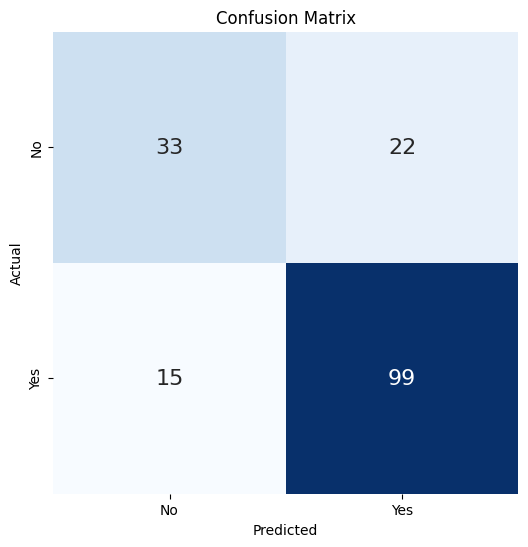

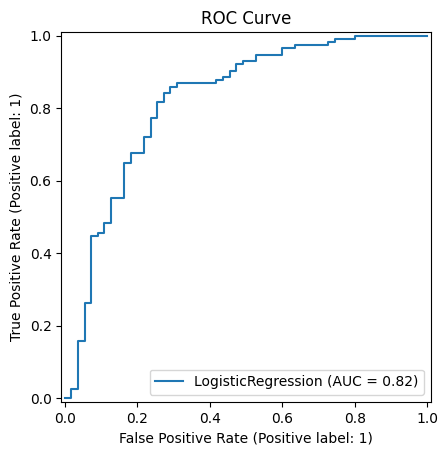

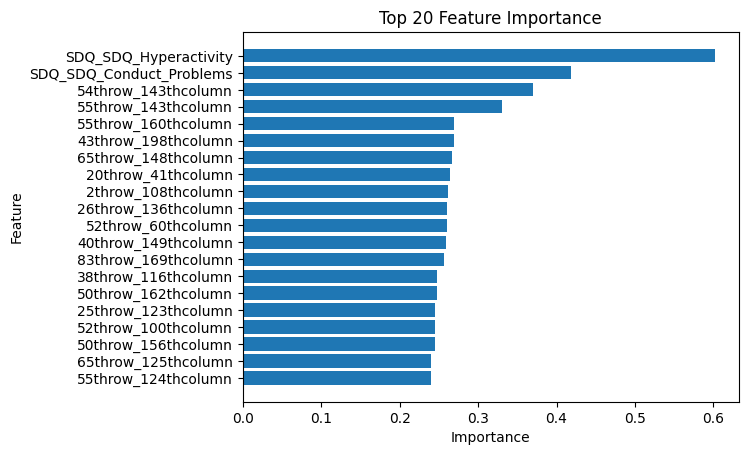

Model saved as lr_model_adhd.joblib


### Sex_F

Accuracy: 0.7337278106508875
Classification Report:
               precision    recall  f1-score   support

        Male       0.75      0.89      0.81       111
      Female       0.68      0.43      0.53        58

    accuracy                           0.73       169
   macro avg       0.71      0.66      0.67       169
weighted avg       0.72      0.73      0.72       169

Confusion Matrix:
 [[99 12]
 [33 25]]


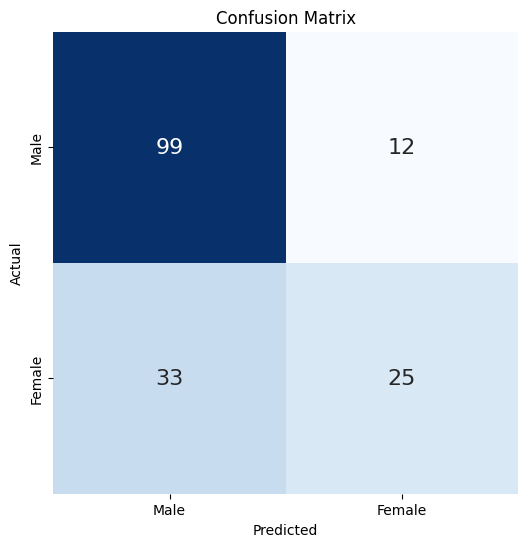

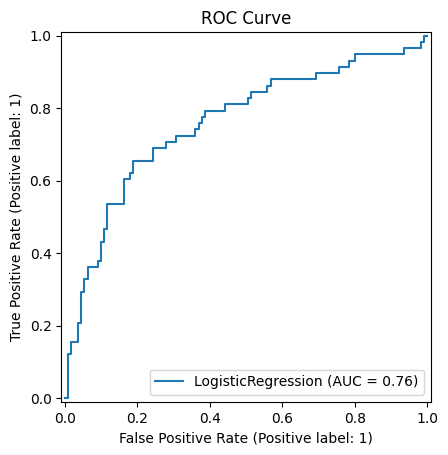

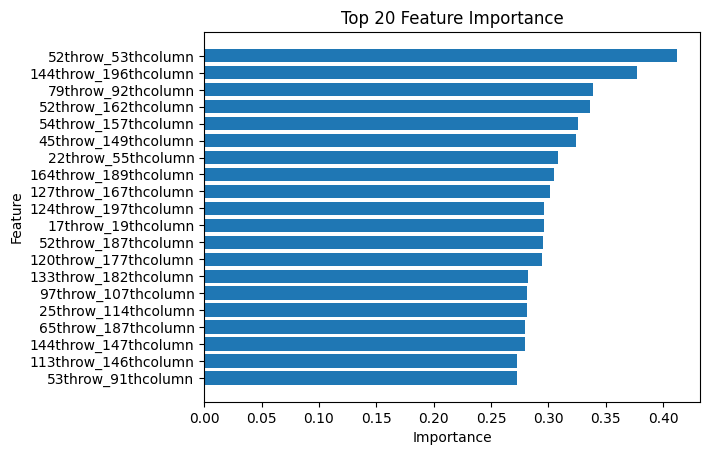

Model saved as lr_model_sex.joblib


In [36]:
def fit_predict_and_metrics(x_train, y_train, x_test, y_test, target_names, model):
    model.fit(x_train, y_train)  # Train the model on the training data
    
    # Make predictions
    y_pred = model.predict(x_test)  # Use the trained model to make predictions on the test set
    
    # Display metrics
    metrics(y_pred, x_train, y_train, x_test, y_test, target_names)
    
    # Plot ROC curve
    RocCurveDisplay.from_estimator(model, x_test, y_test)
    plt.title('ROC Curve')
    plt.show()
    
    # Plot top 20 feature importance
    if hasattr(model, 'coef_'):
        feature_importance = np.abs(model.coef_[0])
    elif hasattr(model, 'feature_importances_'):
        feature_importance = model.feature_importances_
    else:
        raise ValueError("Model does not have feature importance or coefficients.")
    
    feature_names = x_train.columns
    top_20_indices = np.argsort(feature_importance)[-20:]  # Get indices of top 20 features
    top_20_features = feature_names[top_20_indices]
    top_20_importance = feature_importance[top_20_indices]
    
    plt.barh(top_20_features, top_20_importance)
    plt.title('Top 20 Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

def save_model(prefix, model_type, model):
    model_filename = prefix + "_" + model_type + ".joblib"  
    joblib.dump(model, model_filename)
    print(f"Model saved as {model_filename}")

def logistic_regression(x_train, y_train, x_test, y_test, target_names, model_type):
    # Train the logistic regression model
    model = LogisticRegression(class_weight='balanced', max_iter=1000)  # Logistic Regression model

    # Fit, predict, display metrics
    fit_predict_and_metrics(x_train, y_train, x_test, y_test, target_names, model)

    save_model("lr_model", model_type, model)

def launch_model_building(model_building_function):
    display(Markdown('### ADHD_Outcome'))
    model_building_function(x_train_adhd, y_train_adhd, x_test_adhd, y_test_adhd, target_names=['No', 'Yes'], model_type="adhd")
    
    display(Markdown('### Sex_F'))
    model_building_function(x_train_sex, y_train_sex, x_test_sex, y_test_sex, target_names=['Male', 'Female'], model_type="sex")

launch_model_building(logistic_regression)

### Ridge Regularization

### ADHD_Outcome

Accuracy: 0.7810650887573964
Classification Report:
               precision    recall  f1-score   support

          No       0.69      0.60      0.64        55
         Yes       0.82      0.87      0.84       114

    accuracy                           0.78       169
   macro avg       0.75      0.73      0.74       169
weighted avg       0.78      0.78      0.78       169

Confusion Matrix:
 [[33 22]
 [15 99]]


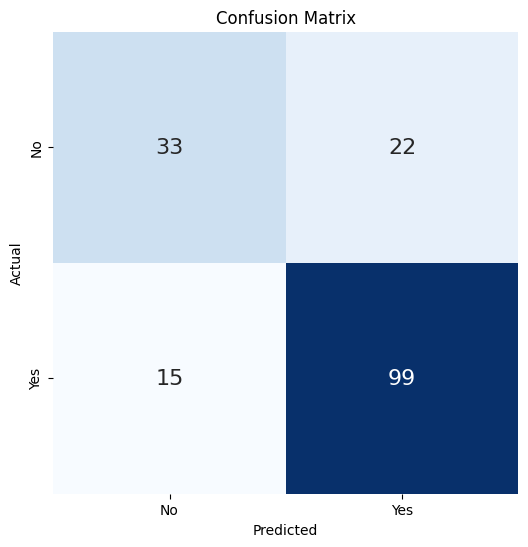

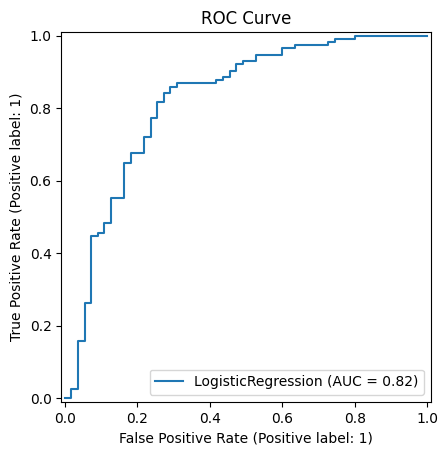

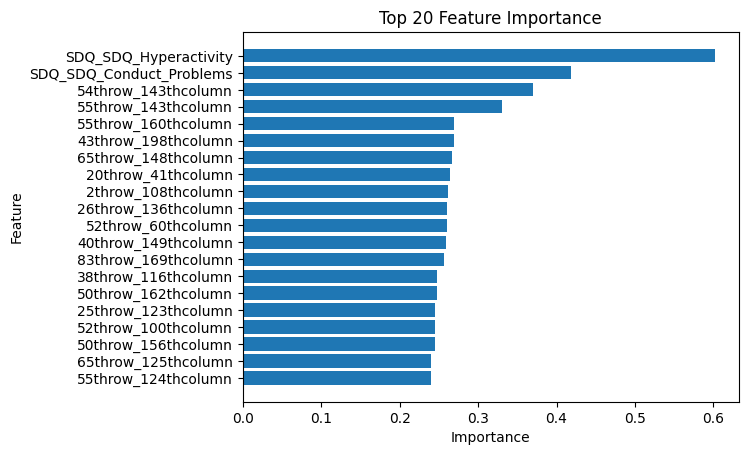

Model saved as lr_model_ridge_adhd.joblib


### Sex_F

Accuracy: 0.7337278106508875
Classification Report:
               precision    recall  f1-score   support

        Male       0.75      0.89      0.81       111
      Female       0.68      0.43      0.53        58

    accuracy                           0.73       169
   macro avg       0.71      0.66      0.67       169
weighted avg       0.72      0.73      0.72       169

Confusion Matrix:
 [[99 12]
 [33 25]]


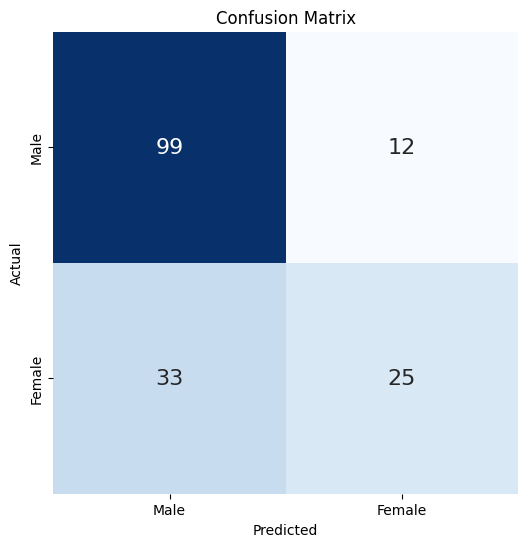

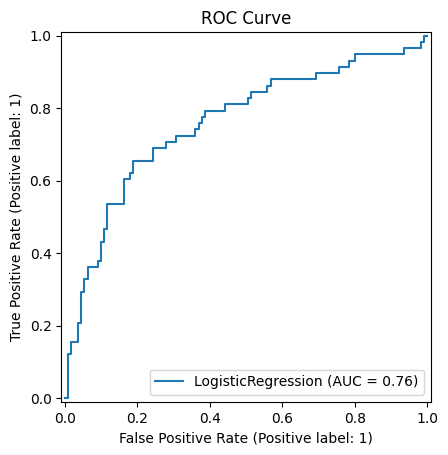

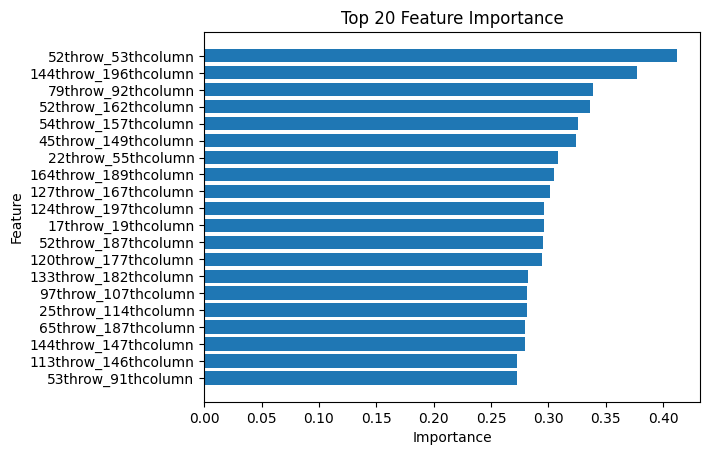

Model saved as lr_model_ridge_sex.joblib


In [37]:
# Logistic Regression with Ridge (L2) Regularization
def logistic_regression_with_ridge(x_train, y_train, x_test, y_test, target_names, model_type, penalty='l2', C=1.0):
    # Train the logistic regression model with regularization
    model = LogisticRegression(class_weight='balanced', max_iter=1000, penalty=penalty, C=C)  # Logistic Regression with regularization

    # Fit, predict, display metrics
    fit_predict_and_metrics(x_train, y_train, x_test, y_test, target_names, model)

    # Save the model using joblib
    save_model("lr_model_ridge", model_type, model)

launch_model_building(logistic_regression_with_ridge)

### Lasso Regularization

### ADHD_Outcome

Accuracy: 0.7751479289940828
Classification Report:
               precision    recall  f1-score   support

          No       0.63      0.73      0.68        55
         Yes       0.86      0.80      0.83       114

    accuracy                           0.78       169
   macro avg       0.75      0.76      0.75       169
weighted avg       0.79      0.78      0.78       169

Confusion Matrix:
 [[40 15]
 [23 91]]


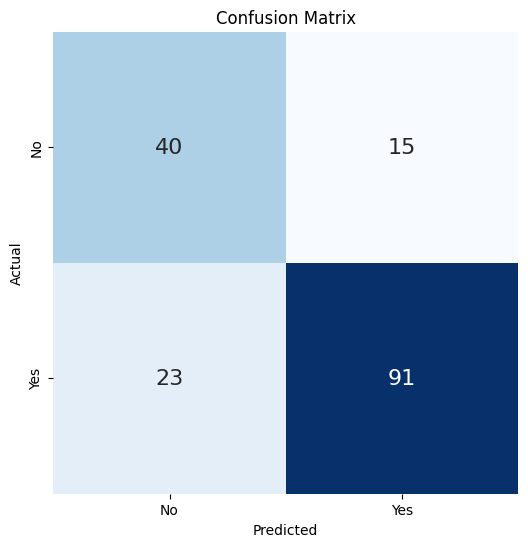

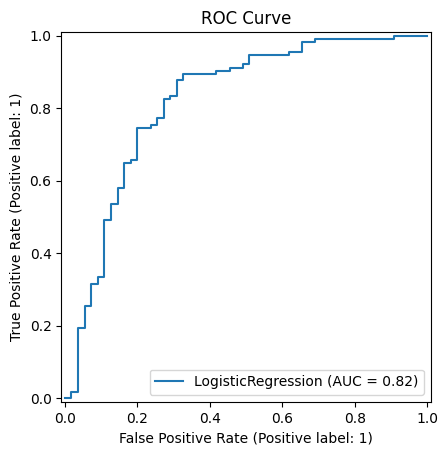

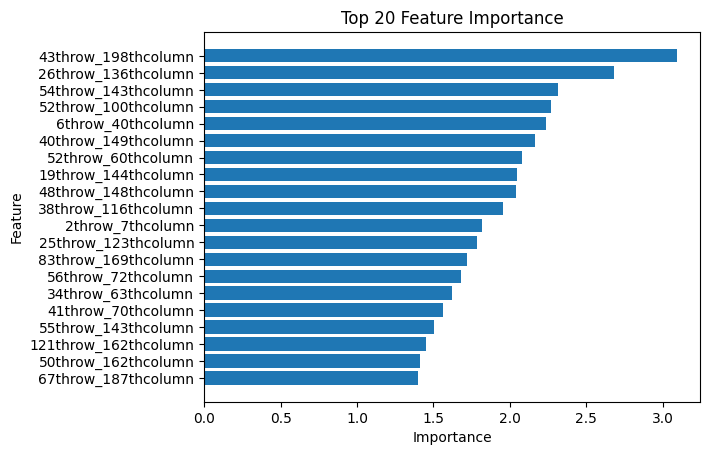

Model saved as lr_model_lasso_adhd.joblib


### Sex_F

Accuracy: 0.6863905325443787
Classification Report:
               precision    recall  f1-score   support

        Male       0.75      0.78      0.77       111
      Female       0.55      0.50      0.52        58

    accuracy                           0.69       169
   macro avg       0.65      0.64      0.64       169
weighted avg       0.68      0.69      0.68       169

Confusion Matrix:
 [[87 24]
 [29 29]]


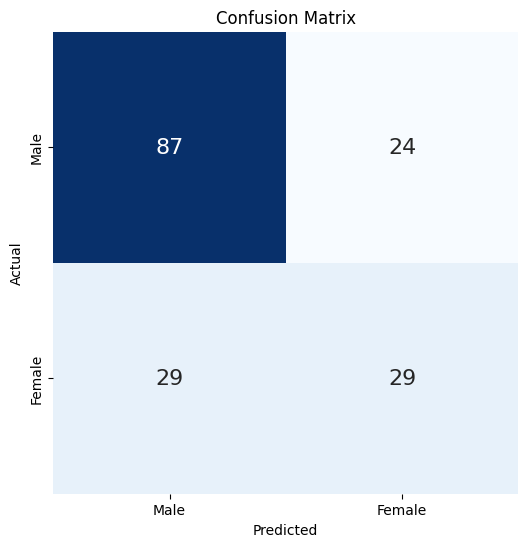

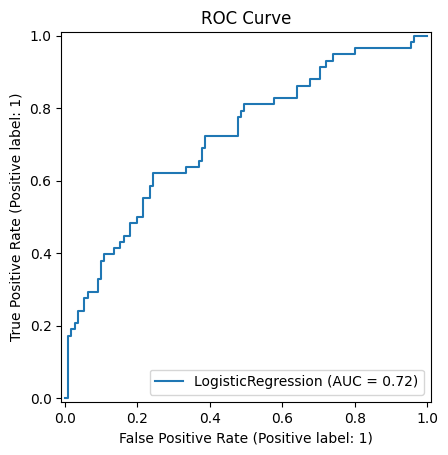

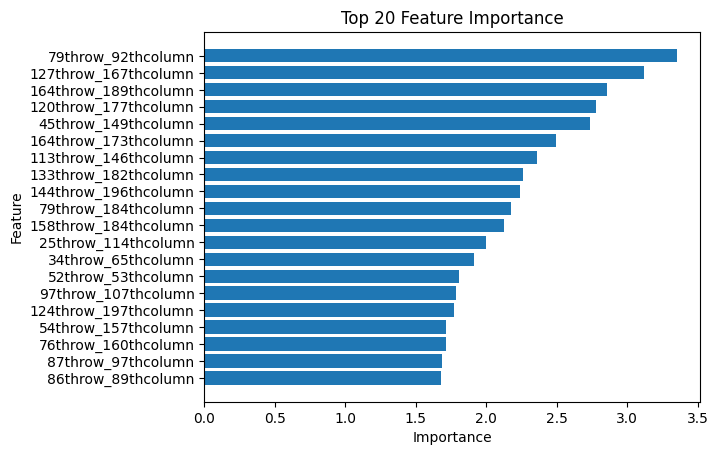

Model saved as lr_model_lasso_sex.joblib


In [38]:
# Logistic Regression with Lasso (L1) Regularization
def logistic_regression_lasso(x_train, y_train, x_test, y_test, target_names, model_type, C=1.0):
    # Train the logistic regression model with Lasso regularization (L1)
    model = LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l1', C=C, solver='liblinear')  # Lasso (L1) regularization

    # Fit, predict, display metrics
    fit_predict_and_metrics(x_train, y_train, x_test, y_test, target_names, model)

    # Save the model using joblib
    save_model("lr_model_lasso", model_type, model)

launch_model_building(logistic_regression_lasso)

### **Random Forest**

#### **Regular Random Forest**

### ADHD_Outcome

Accuracy: 0.6745562130177515
Classification Report:
               precision    recall  f1-score   support

          No       0.00      0.00      0.00        55
         Yes       0.67      1.00      0.81       114

    accuracy                           0.67       169
   macro avg       0.34      0.50      0.40       169
weighted avg       0.46      0.67      0.54       169

Confusion Matrix:
 [[  0  55]
 [  0 114]]


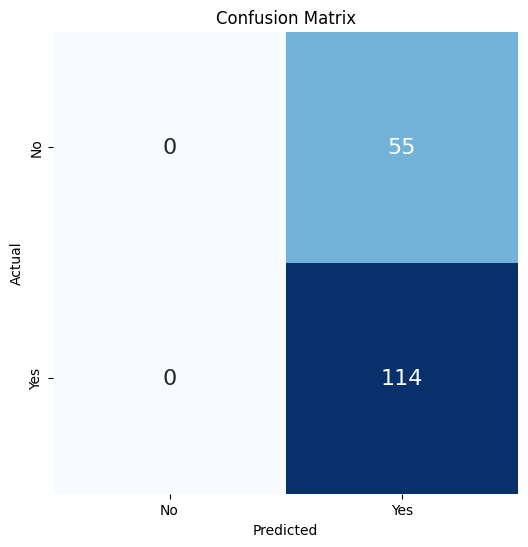

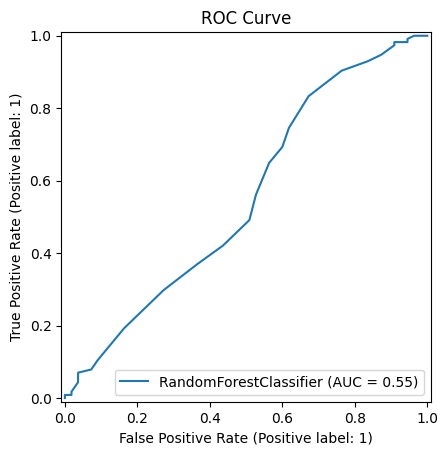

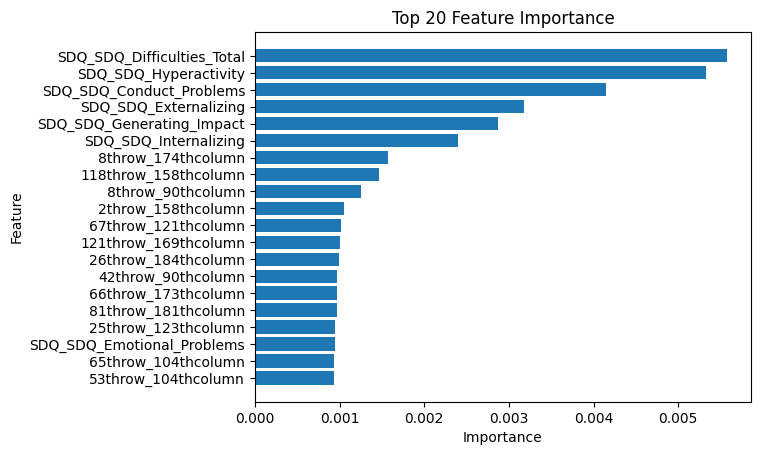

### Sex_F

Accuracy: 0.6568047337278107
Classification Report:
               precision    recall  f1-score   support

        Male       0.66      1.00      0.79       111
      Female       0.00      0.00      0.00        58

    accuracy                           0.66       169
   macro avg       0.33      0.50      0.40       169
weighted avg       0.43      0.66      0.52       169

Confusion Matrix:
 [[111   0]
 [ 58   0]]


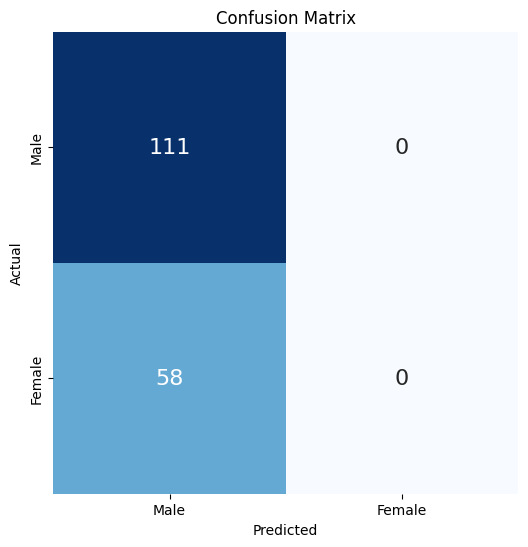

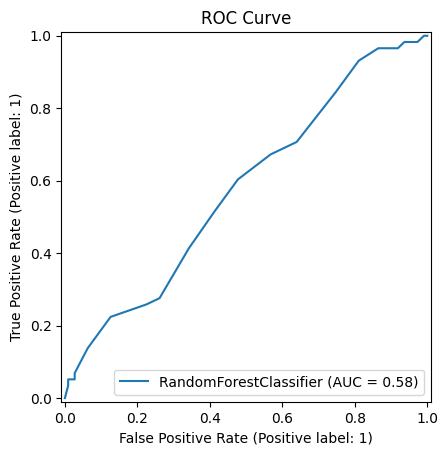

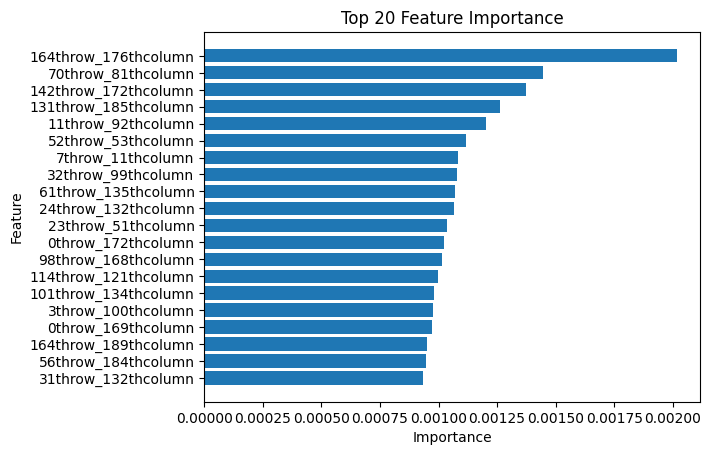

In [39]:
def random_forest(x_train, y_train, x_test, y_test, target_names, model_type):
    # Define the model (using default hyperparameters)
    model = RandomForestClassifier(class_weight='balanced', random_state=42)

    # Fit, predict, display metrics
    fit_predict_and_metrics(x_train, y_train, x_test, y_test, target_names, model)

launch_model_building(random_forest)

#### **Hyperparameter tuning**

### ADHD_Outcome

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10, 'bootstrap': True}
Accuracy: 0.6745562130177515
Classification Report:
               precision    recall  f1-score   support

          No       0.00      0.00      0.00        55
         Yes       0.67      1.00      0.81       114

    accuracy                           0.67       169
   macro avg       0.34      0.50      0.40       169
weighted avg       0.46      0.67      0.54       169

Confusion Matrix:
 [[  0  55]
 [  0 114]]


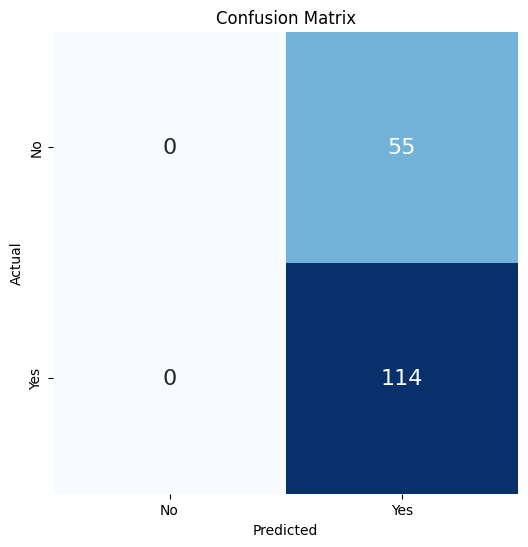

### Sex_F

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': True}
Accuracy: 0.650887573964497
Classification Report:
               precision    recall  f1-score   support

        Male       0.66      0.98      0.79       111
      Female       0.33      0.02      0.03        58

    accuracy                           0.65       169
   macro avg       0.49      0.50      0.41       169
weighted avg       0.55      0.65      0.53       169

Confusion Matrix:
 [[109   2]
 [ 57   1]]


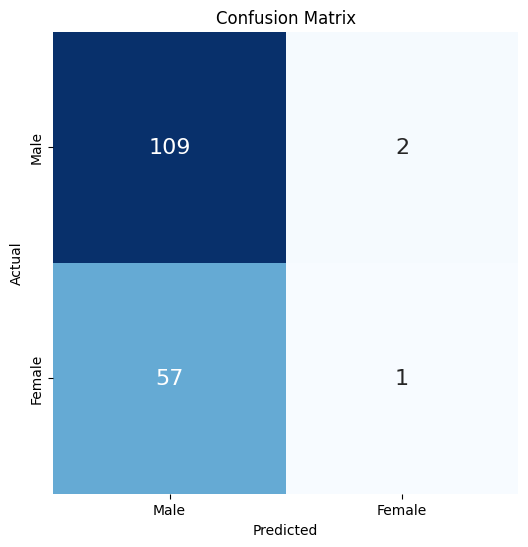

In [40]:
def tuned_random_forest(x_train, y_train, x_test, y_test, target_names, model_type):
    # Define the model
    model = RandomForestClassifier(class_weight='balanced', random_state=42)
    
    # Set a smaller parameters grid for faster tuning
    param_dist = {
        'n_estimators': [50, 100, 150],  # Limit number of trees
        'max_depth': [None, 10, 20],  # Limit depth of trees
        'min_samples_split': [2, 5],  # Lower minimum samples to split
        'min_samples_leaf': [1, 2],  # Lower minimum samples per leaf
        'bootstrap': [True],  # Use bootstrap sampling (True is generally best)
    }
    
    # Use RandomizedSearchCV for faster tuning with fewer iterations
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist, 
        n_iter=5,  # Reduce the number of iterations for faster results
        cv=2,  # Reduce cross-validation folds to speed up the process
        n_jobs=-1,  # Use all available CPU cores
        verbose=2,  # Show progress
        scoring='accuracy',  # Evaluation metric
        random_state=42
    )
    
    # Fit the randomized search to the data (only a subset of the data if needed)
    random_search.fit(x_train, y_train)
    
    # Get the best parameters from RandomizedSearch
    best_params = random_search.best_params_
    print("Best Hyperparameters:", best_params)
    
    # Train the model with the best hyperparameters
    best_model = random_search.best_estimator_
    
    # Make predictions
    y_pred = best_model.predict(x_test)

    # Display metrics
    metrics(y_pred, x_train, y_train, x_test, y_test, target_names)


launch_model_building(tuned_random_forest)

### **XGBoost**

### Regular

### ADHD_Outcome

Accuracy: 0.7692307692307693
Classification Report:
               precision    recall  f1-score   support

          No       0.68      0.55      0.61        55
         Yes       0.80      0.88      0.84       114

    accuracy                           0.77       169
   macro avg       0.74      0.71      0.72       169
weighted avg       0.76      0.77      0.76       169

Confusion Matrix:
 [[ 30  25]
 [ 14 100]]


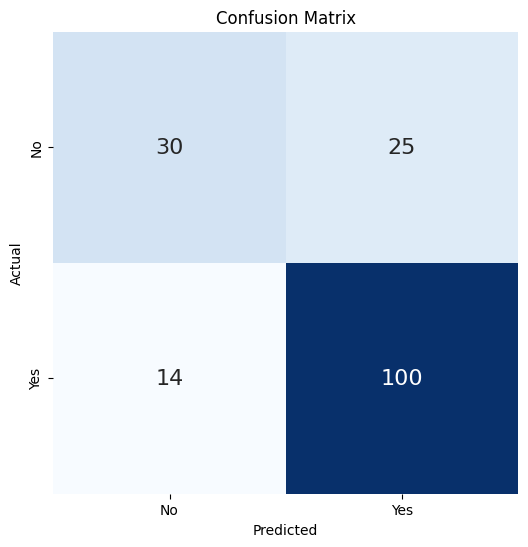

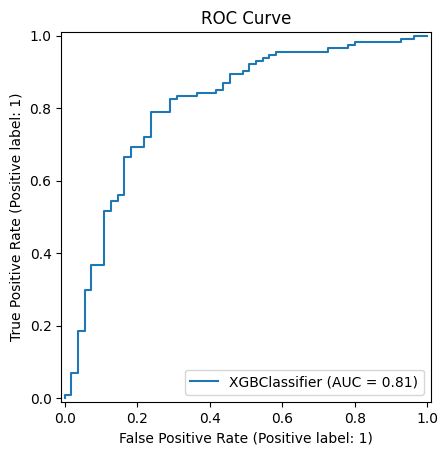

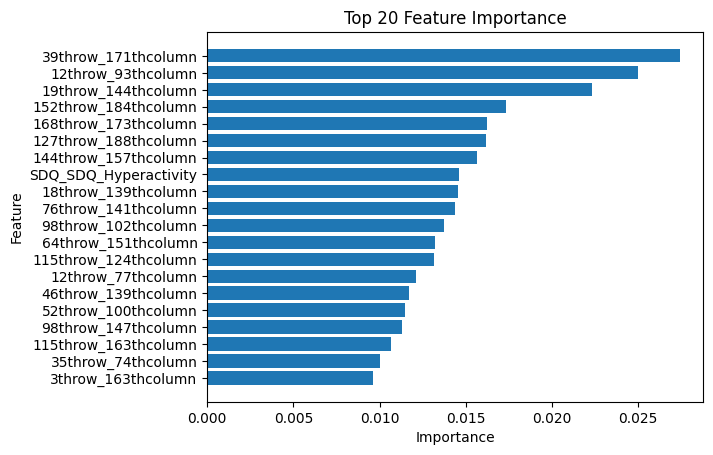

### Sex_F

Accuracy: 0.621301775147929
Classification Report:
               precision    recall  f1-score   support

        Male       0.67      0.85      0.75       111
      Female       0.39      0.19      0.26        58

    accuracy                           0.62       169
   macro avg       0.53      0.52      0.50       169
weighted avg       0.57      0.62      0.58       169

Confusion Matrix:
 [[94 17]
 [47 11]]


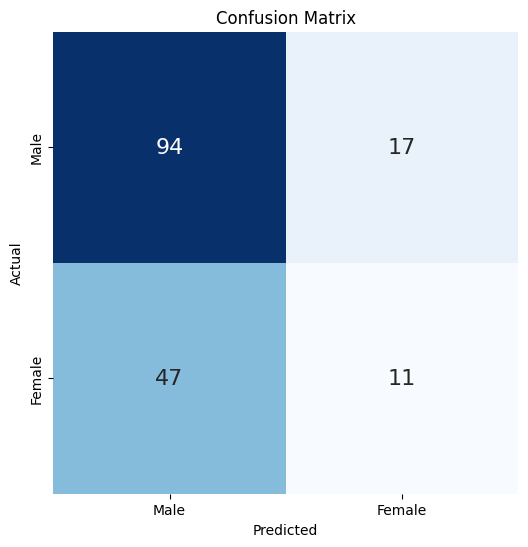

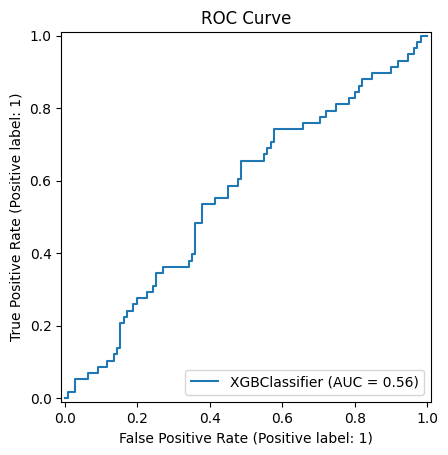

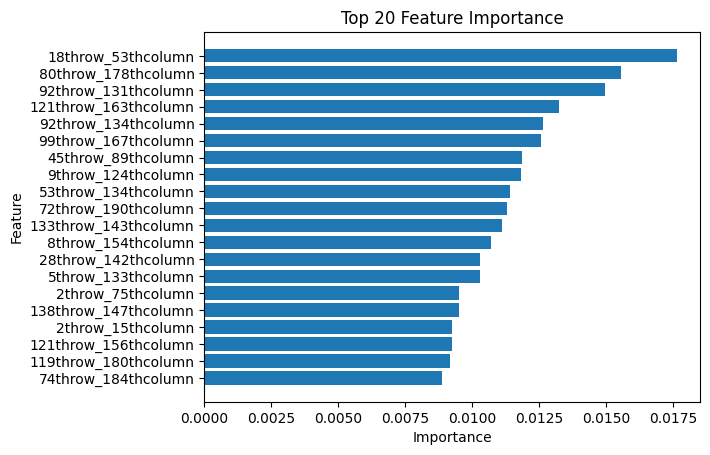

In [41]:
def xgboost_model(x_train, y_train, x_test, y_test, target_names, model_type):
    # Calculate scale_pos_weight for imbalanced classes
    scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)

    # Train the XGBoost model
    model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, n_estimators=100, random_state=42)  # XGBoost model with 100 trees

    # Fit, predict, display metrics
    fit_predict_and_metrics(x_train, y_train, x_test, y_test, target_names, model)

launch_model_building(xgboost_model)

### Tuned

### ADHD_Outcome

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   3.4s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   5.7s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   5.7s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   1.7s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   5.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=1, min_samples_split=2, n_estimators=150; total time=   4.0s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   3.6s
Best H

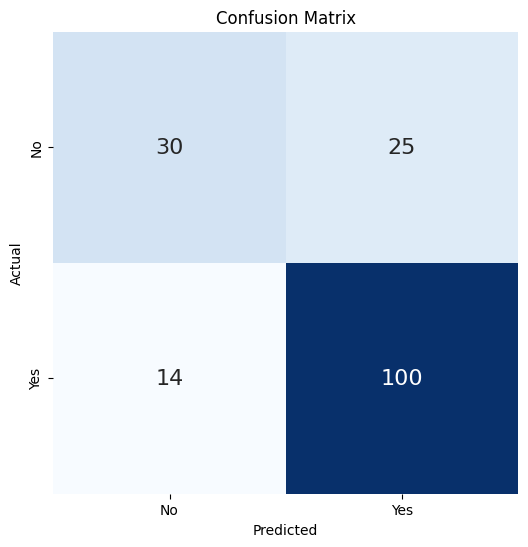

### Sex_F

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time= 2.2min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time= 2.3min
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   4.6s
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=150; total time=   3.8s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8; total time= 2.6min
[CV] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0; total time= 2.8min
Best Hyperp

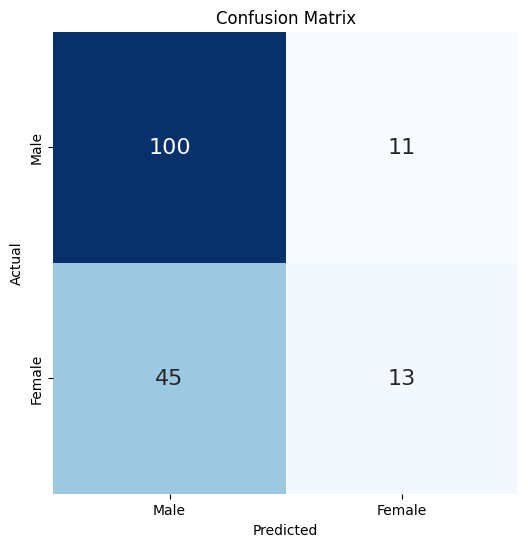

In [42]:
def xgboost_tuned(x_train, y_train, x_test, y_test, target_names, model_type):
    # Calculate scale_pos_weight for imbalanced classes
    scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
    
    # Define the XGBoost model
    model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=42, eval_metric='mlogloss')
    
    # Define a smaller hyperparameter search space
    param_dist = {
        'n_estimators': [100, 200],  # Smaller number of trees
        'max_depth': [3, 6],  # Smaller depth
        'learning_rate': [0.01, 0.1],  # Typical learning rates
        'subsample': [0.8, 1.0],  # Use most of the data
        'colsample_bytree': [0.8, 1.0],  # Use most of the features
    }

    # Use RandomizedSearchCV for faster tuning with fewer iterations
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_dist, 
        n_iter=5,  # Reduce the number of iterations for faster results
        cv=2,  # Reduce cross-validation folds to speed up the process
        n_jobs=-1,  # Use all available CPU cores
        verbose=2,  # Show progress
        scoring='accuracy',  # Evaluation metric
        random_state=42
    )
    
    # Fit the RandomizedSearchCV
    random_search.fit(x_train, y_train)
    
    # Get the best hyperparameters
    best_params = random_search.best_params_
    print("Best Hyperparameters:", best_params)
    
    # Train the model with the best parameters
    best_model = random_search.best_estimator_
    
    # Make predictions on the test data
    y_pred = best_model.predict(x_test)

    # Display metrics
    metrics(y_pred, x_train, y_train, x_test, y_test, target_names)

launch_model_building(xgboost_tuned)

## **Refined Insights**

- Logistic Regression and Logistic Regression with Ridge Regularization performed slightly better than Regression with Lasso Regularization, and much better than Random Forest and XGBoost, and therefore, Logistic Regression Model is the one used for creating results.
- Key metrics for comparing models are F1 Score, Accuracy, Recall, and Precision.

| Metrics | Logistic Regression | LR Ridge | LR Lasso | Random Forest | Tuned RF | XGBoost | Tuned XGBoost |
|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
|  **adhd weighted avg f1-score**   |  0.78   |  0.78   |  0.79   |  0.59    |  0.57   |  0.75   |  0.78    |
|  **adhd macro avg f1-score**   |  0.74  |  0.74   |  0.76   |  0.47   |  0.44   |  0.71   |  0.74   |
|  **sex weighted avg f1-score**   |  0.70   |  0.70   |  0.69   |  0.53  |  0.52   |  0.57   |  0.52   |
|  **sex macro avg f1-score**   |  0.65   |  0.65   |  0.64   |  0.41   |  0.40   |  0.47   |  0.39   |

## **Generate Results**

Load the logistic regression models, make predictions on unseen data, and aggregate the results into "results.csv".

In [43]:
# Function to generate the results file with two separate models
def generate_results(test_data, adhd_model_filename, sex_f_model_filename, output_filename="results.csv"):
    # Load the trained models
    adhd_model = joblib.load(adhd_model_filename)
    sex_f_model = joblib.load(sex_f_model_filename)
    
    # Predict ADHD_Outcome using the ADHD model
    y_pred_adhd = adhd_model.predict(test_data)  # Assuming features are already in test_data, excluding index/participant_id
    # Predict Sex_F using the Sex_F model
    y_pred_sex_f = sex_f_model.predict(test_data)  # Same assumption as above
    
    # Create a DataFrame for the submission
    submission = pd.DataFrame({
        'participant_id': test_data.index,  # Use index as participant_id
        'ADHD_Outcome': y_pred_adhd.astype(int),  # Predicted ADHD_Outcome
        'Sex_F': y_pred_sex_f.astype(int)  # Predicted Sex_F
    })
    
    # Save the results to a CSV file
    submission.to_csv(output_filename, index=False, header=True)
    print(f"Results file saved as {output_filename}")

# Generate the results file
generate_results(unseen_data_combined, "lr_model_adhd.joblib", "lr_model_sex.joblib")


Results file saved as results.csv
